In [1]:
# 如果您使用 Colab，建議先確認是否使用 GPU
# 在程式最上方執行以下指令:
# Runtime -> Change runtime type -> Hardware accelerator -> GPU

!nvidia-smi

Wed Jan  8 15:18:36 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
import os
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

# 檢查 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# 如果尚未下載，可以先執行這段
!git clone https://github.com/chauhanarpit09/Face-Mask-Detection-.git

Cloning into 'Face-Mask-Detection-'...
remote: Enumerating objects: 4547, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 4547 (delta 11), reused 0 (delta 0), pack-reused 4523 (from 1)
Receiving objects: 100% (4547/4547), 176.67 MiB | 34.40 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (4678/4678), done.


In [4]:
# 設定資料路徑（已指定在 prompt 裡）
train_dir = "/content/Face-Mask-Detection-/facemask/train"
valid_dir = "/content/Face-Mask-Detection-/facemask/valid"

# 定義影像處理與資料增強
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      # ResNet-18 可用 224x224
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # ImageNet 平均/標準差
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 建立資料集 (ImageFolder)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=valid_transforms)

# 建立 DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=32,
                                           shuffle=False)

# 取得類別索引與名稱
class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

Classes: ['with_mask', 'without_mask']
Number of classes: 2


In [5]:
# 載入 ResNet-18 預訓練模型 (ImageNet)
model = models.resnet18(pretrained=True)

# 凍結所有參數，不進行反向傳遞
for param in model.parameters():
    param.requires_grad = False

# 重新定義最後一層全連接層 (fc)
# 原本的輸出是 1000 類 (ImageNet)，現在改為 2 類
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# 移動到 GPU (若可用)
model = model.to(device)

# 定義損失函式與最佳化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [7]:
num_epochs = 5  # 可自行調整
best_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate_one_epoch(model, valid_loader, criterion, device)

    # 若驗證集表現更好，則保存模型 (示範)
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), "best_resnet18_mask.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f} ")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5] Train Loss: 0.3008, Train Acc: 0.8843 | Valid Loss: 0.1265, Valid Acc: 0.9767 
Epoch [2/5] Train Loss: 0.1469, Train Acc: 0.9548 | Valid Loss: 0.0858, Valid Acc: 0.9833 
Epoch [3/5] Train Loss: 0.1088, Train Acc: 0.9644 | Valid Loss: 0.0712, Valid Acc: 0.9800 
Epoch [4/5] Train Loss: 0.0883, Train Acc: 0.9742 | Valid Loss: 0.0748, Valid Acc: 0.9833 
Epoch [5/5] Train Loss: 0.0871, Train Acc: 0.9697 | Valid Loss: 0.0553, Valid Acc: 0.9867 


In [12]:
# 測試前，先載入最佳權重 (如有需要)
# model.load_state_dict(torch.load("best_resnet18_mask.pth"))

# 與訓練/驗證相同的轉換
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def predict_image_from_url(url, model, device, class_names):
    # 下載圖片
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    # 顯示圖片
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # 轉換為張量
    img_tensor = test_transforms(img).unsqueeze(0)  # (1, 3, 224, 224)
    img_tensor = img_tensor.to(device)

    # 模型預測
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)

    # 預測類別
    pred_class = class_names[preds.item()]
    print(f"預測類別: {pred_class}")
    return pred_class

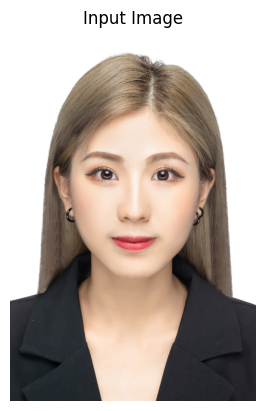

預測類別: without_mask


'without_mask'

In [16]:
test_url = "https://www.sayho.com/wp-content/uploads/2022/01/%E8%AA%AA%E5%A5%BD%E6%94%9D%E5%BD%B1-%E9%9F%93%E5%BC%8F%E8%AD%89%E4%BB%B6%E7%85%A7.jpg"
predict_image_from_url(test_url, model, device, class_names)